# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

### 3.1 Loading the dataset

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import sys

sys.path.append('../../src/utils')


# Utilities
from housing_prices_column_definition import Column

sourceDataset = '../../datasets/processed/housing_prices/hyderabad_house_price_cleanup.parquet'
targetDataset = '../../datasets/processed/housing_prices/hyderabad_house_price_feauture_eng.parquet'

train_features_path = '../../datasets/processed/housing_prices/hyderabad_house_price_training_features.parquet'
train_labels_path = '../../datasets/processed/housing_prices/hyderabad_house_price_training_labels.parquet'

test_features_path = '../../datasets/processed/housing_prices/hyderabad_house_price_test_features.parquet'
test_labels_path = '../../datasets/processed/housing_prices/hyderabad_house_price_test_labels.parquet'

dataset = pd.read_parquet(sourceDataset)

## 3.2 Transformation of Skewed Numerical Features

**Problem:**
The numerical features Price and Area have highly right-skewed distributions, as observed in their descriptive statistics (the mean is significantly greater than the median). This can negatively affect the performance of models that are sensitive to the scale and distribution of the data, such as linear models.

**Justification:**

A logarithmic transformation (np.log1p) compresses the range of the higher values, reducing the impact of outliers and making the distribution more symmetrical (similar to a normal distribution). This helps to stabilize the variance and meet the assumptions of many Machine Learning algorithms, which generally leads to better performance and a more robust model.

**Action:**

- Apply the np.log1p transformation to the Price and Area columns to normalize their distribution.
- It is not advisable to apply a logarithmic transformation to the No. of Bedrooms column. Unlike Price and Area, this variable is not continuous, but discrete, and has a very small and limited range of values (e.g., 1, 2, 3, 4, 5 bedrooms). Logarithmic transformation will not provide any benefits and will complicate the interpretation of the model.

**Verification:**

Before (left) and after (right) applying logarithm


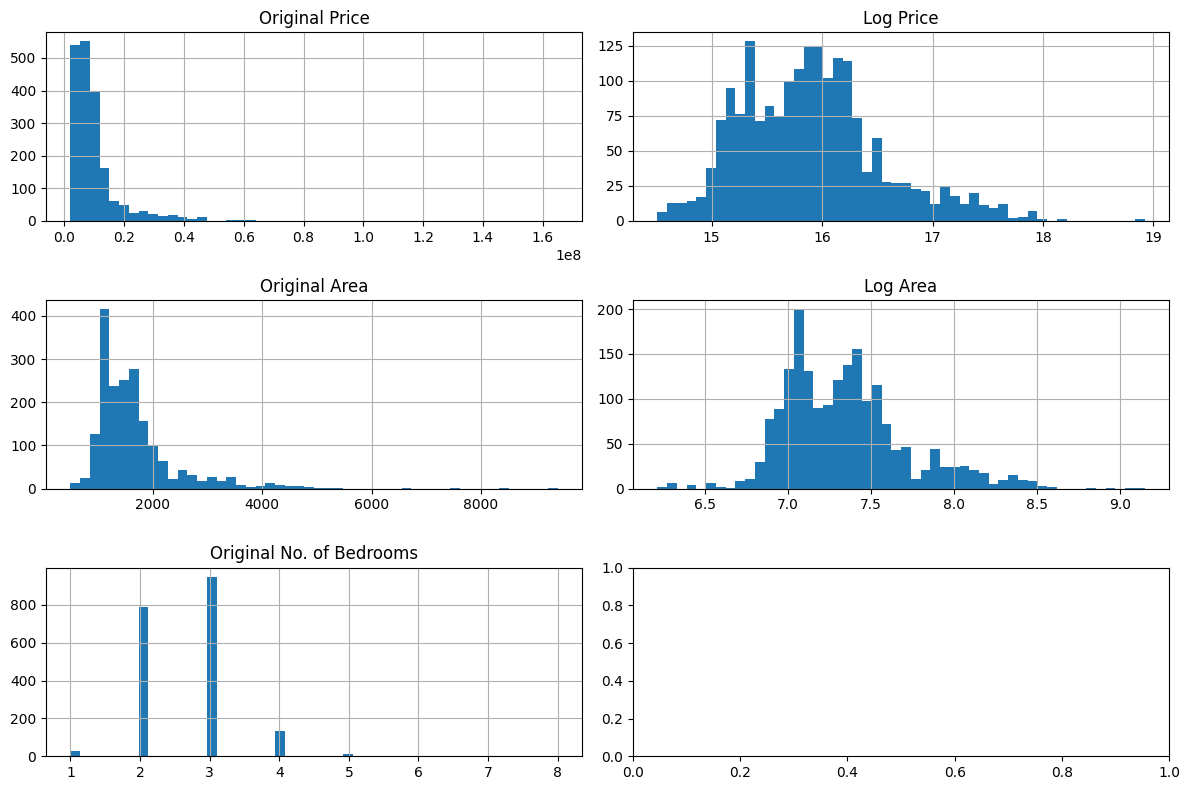

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

dataset[Column.PRICE.name].hist(ax=axes[0,0], bins=50).set_title('Original Price')
dataset[Column.AREA.name].hist(ax=axes[1,0], bins=50).set_title('Original Area')
dataset[Column.NO_OF_BEDROOMS.name].hist(ax=axes[2,0], bins=50).set_title('Original No. of Bedrooms')

dataset[Column.PRICE.name] = np.log1p(dataset[Column.PRICE.name])
dataset[Column.AREA.name] = np.log1p(dataset[Column.AREA.name])

dataset[Column.PRICE.name].hist(ax=axes[0,1], bins=50).set_title('Log Price')
dataset[Column.AREA.name].hist(ax=axes[1,1], bins=50).set_title('Log Area')

display(Markdown('**Verification:**'))
print("Before (left) and after (right) applying logarithm") 
plt.tight_layout()
plt.show()

dataset.to_parquet(targetDataset)

## 3.3 Grouping Infrequent Locations and Hot encoding

**Problem:**

Machine learning algorithms require numeric inputs. The Location column is categorical and has a very high number of unique values (high cardinality), which makes standard One-Hot Encoding impractical.

**Justification:**

Creating a separate column for each of the 239 locations would lead to the "curse of dimensionality," making the model unnecessarily complex and potentially prone to overfitting. A more effective strategy is to group infrequent locations into a single "Other" category. This approach reduces the number of dimensions while retaining the most statistically significant locations. We can then apply One-Hot Encoding to this simplified set of categories.

**Action:**

- Identify all locations that appear fewer times than a specified threshold (e.g., 10 times).
- Replace these infrequent location names with the string "Other".
- Apply pd.get_dummies to the modified Location column to create the final numeric features.
- Amenities columns do not need to be converted to one-hot encoding because they are already in a binary or Boolean format that is understandable by machine learning algorithms.
-  The variable No of Bedrooms is a discrete numeric variable, not nominal categorical, which means its values have an inherent and significant order of magnitude. In practice, applying one-hot encoding to this variable is a mistake.

In [17]:
location_counts = dataset[Column.LOCATION.name].value_counts()
threshold = 10

unique_locations_before = dataset[Column.LOCATION.name].nunique()
infrequent_locations = location_counts[location_counts < threshold].index
locations_modified = dataset[Column.LOCATION.name].replace(infrequent_locations, 'Other')
uniqueLocationAfter = locations_modified.nunique()

location_dummies = pd.get_dummies(locations_modified, prefix=Column.LOCATION.name, drop_first=True)

dataset_with_dummies = pd.concat([dataset.drop(columns=Column.LOCATION.name), location_dummies], axis=1)

display(Markdown('**Verification:**'))
print(f"Number of unique locations before clustering {unique_locations_before}") 
print(f"Number of unique locations after clustering: {uniqueLocationAfter}")


dataset_with_dummies.to_parquet(targetDataset)

**Verification:**

Number of unique locations before clustering 239
Number of unique locations after clustering: 50


## 3.4 Evaluate binding in No of Bedrooms


**Problem:**

We must ensure that the No of Bedrooms column, which is a discrete numeric variable, correlates with our label (Price). If it does not, we may be able to obtain better results by applying binding.

**Justification:**

If we detect that No of Bedrooms has no correlation with Price, we are more likely to obtain better predictions if we apply binding to the column.

**Action:**

Should not use binning on the No. of Bedrooms feature because its relationship with Price is monotonic and largely linear. This means that as the number of bedrooms increases, the price predictably tends to increase as well.

                    Price  No. of Bedrooms
Price            1.000000         0.711704
No. of Bedrooms  0.711704         1.000000


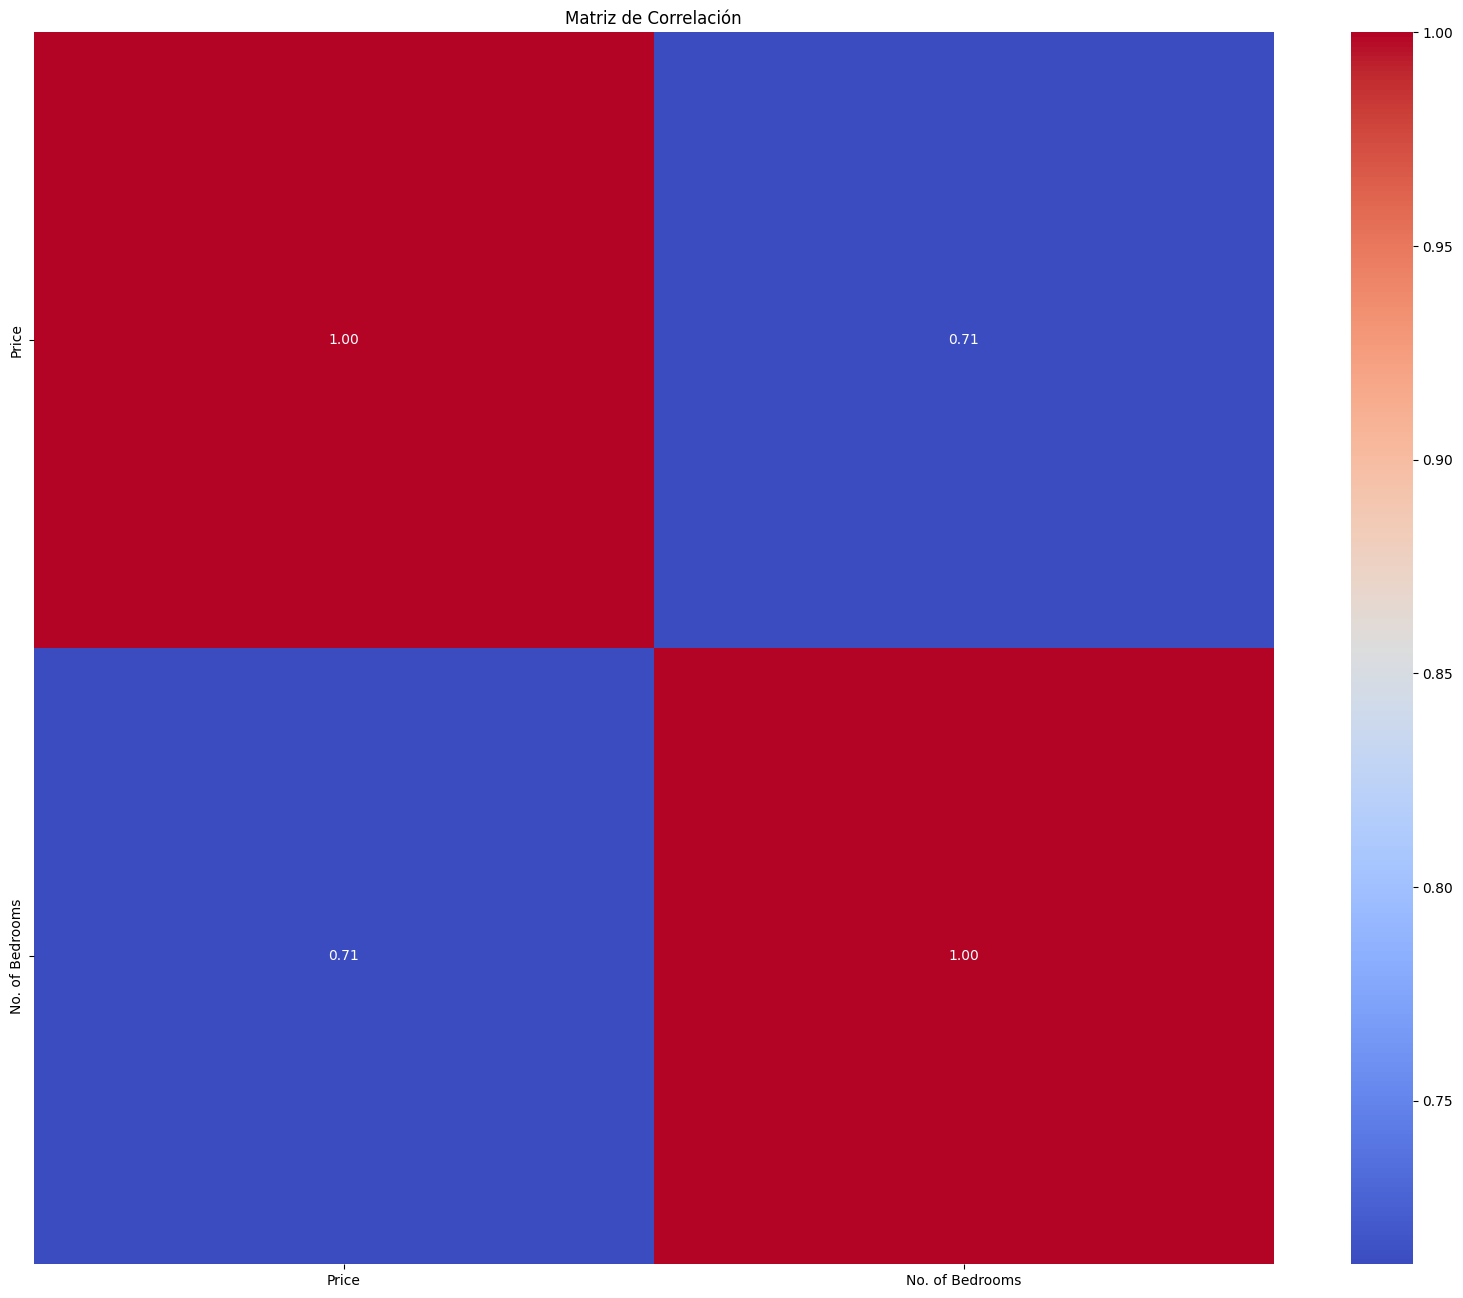

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr = dataset_with_dummies[[Column.PRICE.name, Column.NO_OF_BEDROOMS.name]].corr()
print(corr)

# HitMap
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### 3.5 Split data

**Problem:**

A simple random split of the dataset into training, validation, and test sets can create imbalanced subsets. This means one set might accidentally contain a disproportionate number of expensive or cheap houses compared to the others. A model trained on such a skewed dataset will develop a bias, leading to poor generalization and inaccurate performance metrics when evaluated on the other sets.

**Justification:**

For a model's evaluation to be reliable, the training, validation, and test sets must be representative samples of the overall data distribution. By ensuring that the statistical properties of the target variable (in this case, the distribution of house prices) are consistent across all splits, we guarantee that the model learns the true underlying patterns from the data. This results in a more robust model that performs predictably on new, unseen data, and our evaluation metrics will reflect its true capabilities.

**Action:**

We will use stratified sampling to perform the data split. This technique divides the data into homogeneous subgroups (strata) based on the price distribution before sampling. By drawing proportional samples from each stratum to build the training, validation, and test sets, we ensure that each set is a faithful and balanced representation of the original dataset's price distribution.


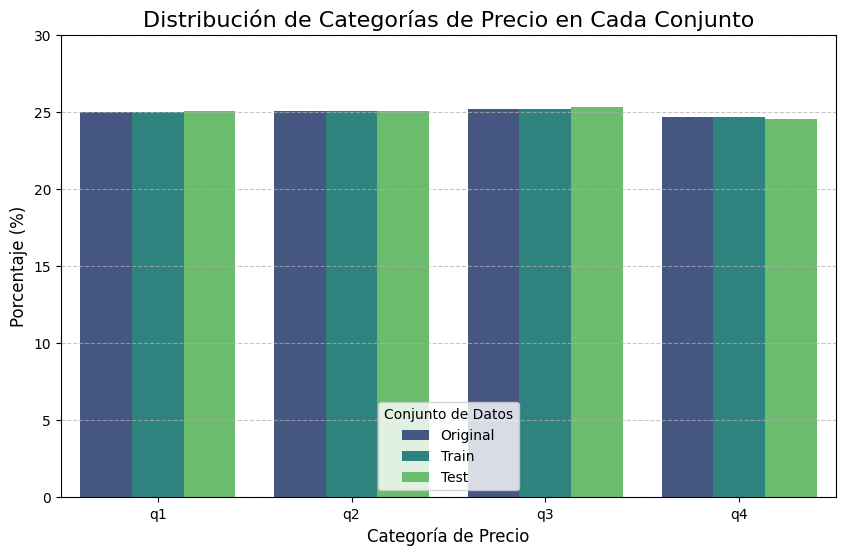

In [20]:

PRICE_CAT = 'price_cat'

processedDataset = pd.read_parquet(targetDataset)
processedDataset[PRICE_CAT] = pd.qcut(processedDataset[Column.PRICE.name], q=4, labels=['q1', 'q2', 'q3', 'q4'])

features = processedDataset.drop(Column.PRICE.name, axis=1)
labels = processedDataset[Column.PRICE.name]

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, stratify=features[PRICE_CAT], random_state=42
)

# # give the proportion of q1, q2, q3, q4 for each set
original_dist = features[PRICE_CAT].value_counts(normalize=True).sort_index()
train_dist = features_train[PRICE_CAT].value_counts(normalize=True).sort_index()
test_dist = features_test[PRICE_CAT].value_counts(normalize=True).sort_index()

comparison_df = pd.DataFrame({
    "Original": original_dist * 100,
    "Train": train_dist * 100,
    "Test": test_dist * 100
})


plot_data = comparison_df.reset_index().melt(
    id_vars=PRICE_CAT,
    var_name='Set',
    value_name='Percentage'
)


plot_data.rename(columns={PRICE_CAT: 'Price Category'}, inplace=True)

# Creamos el gráfico de barras (sin cambios)
plt.figure(figsize=(10, 6))
sns.barplot(x='Price Category', y='Percentage', hue='Set', data=plot_data, palette='viridis')

plt.title('Distribución de Categorías de Precio en Cada Conjunto', fontsize=16)
plt.xlabel('Categoría de Precio', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.ylim(0, 30)
plt.legend(title='Conjunto de Datos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig('stratified_split_verification.png')
plt.show()


# Limpieza final de la columna 'price_cat'
for set_ in (features_train, features_test):
    set_.drop(PRICE_CAT, axis=1, inplace=True)


features_train.to_parquet(train_features_path)
labels_train.to_frame().to_parquet(train_labels_path)

features_test.to_parquet(test_features_path)
labels_test.to_frame().to_parquet(test_labels_path)
